In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.Citeseer import Citeseer
import dgl.function as fn

import torch
import numpy as np

torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
dataset = Citeseer() 

original_graph = dataset.load_graph(n_components = 10)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
original_graph = original_graph.to(device=device)
print(device)
dataset2 = Citeseer()
original_graph_2 = dataset2.load_graph(n_components = None)
original_graph_2 = original_graph_2.to(device=device)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
cuda:1
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
original_graph = dataset.load_graph(n_components = 50)
from Projections.JLRandom import JLRandomProjection
original_graph = original_graph.to(device=device)
from Projections.CCA import CCA

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type,initial_k_layer=2, device=device, pairs_per_level=10,norm_p=1, approx_neigh=True, 
                                add_feat=False, use_out_degree=True, use_zscore=False   , use_cos_sim=False, cca_cls=CCA      ,folder_name="test" , checkpoints=[0.99]           ) # , projection_cls= JLRandomProjection

coarsener.init()
coarsener.summarize()


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


cites
step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:395: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:39.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9981965734896303
step: 2, ratio: 0.9963931469792606
step: 3, ratio: 0.9945897204688909
step: 4, ratio: 0.9927862939585211
step: 5, ratio: 0.9909828674481514


In [4]:
coarsend_graph = coarsener.summarized_graph
mapping = coarsener.get_mapping("paper")
#coarsener.make_mask(mapping, "paper")
labels = coarsener.get_labels( mapping, "paper")

coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() )    


ratio 0.9891794409377818


In [ ]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Experiments.model_helper import run_experiments
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Experiments.plots import plot_bar, plot_line

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph, HeteroGCNCiteer, num_runs=1, target_node_type="paper", epochs=600,eval_interval=1)
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


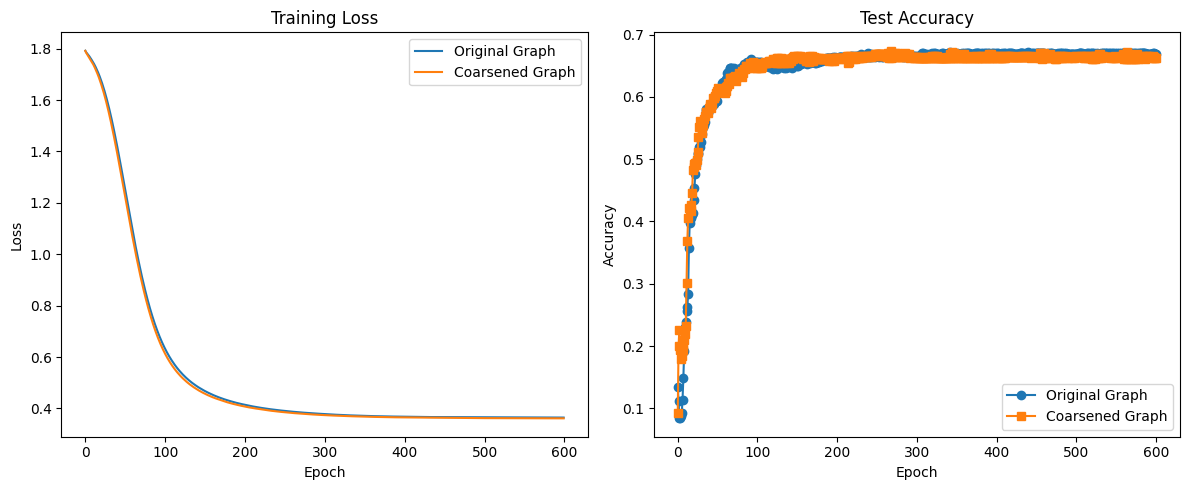

Final Performance Comparison:
Original Graph Accuracy: 0.6680
Coarsened Graph Accuracy: 0.6620

Original Graph Accuracy:
  Mean: 0.6680
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.6620
  Std:  0.0000


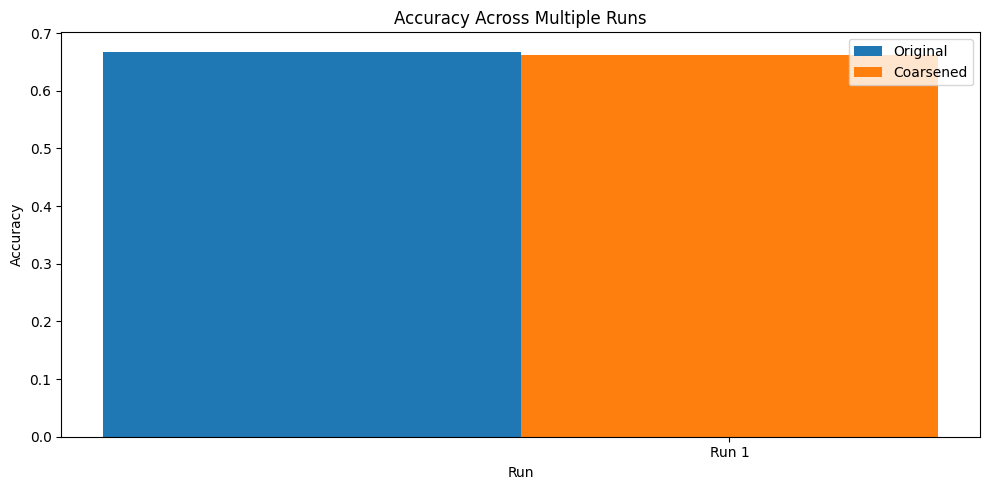

In [16]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(600))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)